In [1]:
!nvidia-smi

Sat Jul 27 04:36:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P0              27W /  72W |    680MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [3]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from transformers import AutoTokenizer, AutoConfig

In [4]:
from common.utils import fixSEED, is_gpu_memory_availabe, callData, splitData # custom functions
from common.datasets import TransformerDataset # custom dataset
from models.transformer import BD_Transformer # transformer model
from common.trainer import Trainer # custom model trainer

In [5]:
# 시드 고정
SEED = 42
fixSEED(seed=SEED)

In [6]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path {}'.format(os.getcwd()))

Current path /home/leesanghyuk2000/Python_Programs


In [7]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# gpu 메모리 확인
is_gpu_memory_availabe()

남은 GPU 메모리: 21.96 GB


### 1. 데이터 불러오기

In [9]:
# youtube data 불러오기
data = callData('caption_data(11285).pkl')

레이블 0 개수 : 7774
레이블 1 개수 : 3511


In [10]:
data.rename(columns={'caption':'text'}, inplace=True)

### 2. Train/Test/Valid

In [12]:
# Split into Train/Valid/Test
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6771개 
검증용 데이터 개수 : 2257개 
평가용 데이터 개수 : 2257개


### 3. 학습 진행

In [13]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [14]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 128

# text 토크나이저 정의
text_checkpoint = "klue/roberta-small"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

In [15]:
# 데이터셋 정의
train_dataset = TransformerDataset(train_data, tokenizer, max_length)
valid_dataset = TransformerDataset(valid_data, tokenizer, max_length)
test_dataset = TransformerDataset(test_data, tokenizer, max_length)

In [16]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[   0, 1676, 3769,  ..., 4396,  555,    2],
         [   0, 3660, 3797,  ...,    1,    1,    1],
         [   0, 3739, 7887,  ..., 3790, 2052,    2],
         ...,
         [   0, 3686, 2614,  ..., 2069, 4848,    2],
         [   0, 7069, 3812,  ..., 1830, 2587,    2],
         [   0,  648, 2205,  ..., 4601, 5775,    2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         1, 1, 1, 1, 0, 0, 0, 1])]

In [17]:
# Model
text_config = AutoConfig.from_pretrained(text_checkpoint)

model = BD_Transformer(text_config)
model.to(device)

BD_Transformer(
  (text_model): TransformerEncoder(
    (embeddings): Embeddings(
      (token_embeddings): Embedding(32000, 768)
      (position_embeddings): PositionalEncoding()
      (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layer_norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-11): 12 x AttentionHead(
              (q): Linear(in_features=768, out_features=64, bias=True)
              (k): Linear(in_features=768, out_features=64, bias=True)
              (v): Linear(in_features=768, out_features=64, bias=True)
            )
          )
          (output_linear): Linear(in_features=768, out_features=768, bias=True)
        )
        (feed_forward): Feed

In [18]:
print_trainable_parameters(model)

Trainable Params: 68812290 
All params: 68812290
--------------------------------------------------
Trainable(%): 100.0


In [19]:
# 학습 파라미터
num_epochs = 10
wait_for_es = 5

learning_rate = 2e-5
wd_rate = 3e-3
eps_rate = 1e-8

In [20]:
# 손실함수, 옵티마이저, Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wd_rate, eps=eps_rate)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [21]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [22]:
is_gpu_memory_availabe()

남은 GPU 메모리: 21.71 GB


In [23]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

------------------------------------------------------------------------------------------------------------------------
Epoch 1/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:17<00:00,  3.98it/s]


[Train] 	 Loss: 0.5352 	 Acc: 0.7312 	 Precision: 0.5190 	 Recall: 0.3263 	 F1: 0.3655
[Valid] 	 Loss: 0.4646 	 Acc: 0.7913 	 Precision: 0.6432 	 Recall: 0.7616 	 F1: 0.6864
▶️ Epoch 1 complete in 1m 37s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.7913.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 2/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


[Train] 	 Loss: 0.3764 	 Acc: 0.8458 	 Precision: 0.8343 	 Recall: 0.6454 	 F1: 0.7059
[Valid] 	 Loss: 0.3359 	 Acc: 0.8699 	 Precision: 0.8448 	 Recall: 0.7101 	 F1: 0.7639
▶️ Epoch 2 complete in 3m 16s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.8699.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 3/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.88it/s]


[Train] 	 Loss: 0.3041 	 Acc: 0.8815 	 Precision: 0.8670 	 Recall: 0.7381 	 F1: 0.7863
[Valid] 	 Loss: 0.2977 	 Acc: 0.8839 	 Precision: 0.8580 	 Recall: 0.7309 	 F1: 0.7800
▶️ Epoch 3 complete in 4m 56s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.8839.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 4/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


[Train] 	 Loss: 0.2675 	 Acc: 0.8983 	 Precision: 0.8928 	 Recall: 0.7677 	 F1: 0.8161
[Valid] 	 Loss: 0.2698 	 Acc: 0.8984 	 Precision: 0.8996 	 Recall: 0.7547 	 F1: 0.8123
▶️ Epoch 4 complete in 6m 35s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.8984.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 5/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.91it/s]


[Train] 	 Loss: 0.2361 	 Acc: 0.9112 	 Precision: 0.9028 	 Recall: 0.8015 	 F1: 0.8406
[Valid] 	 Loss: 0.2716 	 Acc: 0.8975 	 Precision: 0.8211 	 Recall: 0.8609 	 F1: 0.8331
▶️ Epoch 5 complete in 8m 14s
------------------------------------------------------------------------------------------------------------------------
Epoch 6/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.74it/s]


[Train] 	 Loss: 0.2200 	 Acc: 0.9185 	 Precision: 0.9124 	 Recall: 0.8218 	 F1: 0.8558
[Valid] 	 Loss: 0.2418 	 Acc: 0.9094 	 Precision: 0.8717 	 Recall: 0.8276 	 F1: 0.8417
▶️ Epoch 6 complete in 9m 54s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.9094.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 7/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.91it/s]


[Train] 	 Loss: 0.1951 	 Acc: 0.9303 	 Precision: 0.9253 	 Recall: 0.8447 	 F1: 0.8764
[Valid] 	 Loss: 0.2297 	 Acc: 0.9120 	 Precision: 0.9033 	 Recall: 0.8033 	 F1: 0.8440
▶️ Epoch 7 complete in 11m 34s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.9120.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 8/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.92it/s]


[Train] 	 Loss: 0.1830 	 Acc: 0.9342 	 Precision: 0.9339 	 Recall: 0.8535 	 F1: 0.8848
[Valid] 	 Loss: 0.2270 	 Acc: 0.9173 	 Precision: 0.8830 	 Recall: 0.8485 	 F1: 0.8606
▶️ Epoch 8 complete in 13m 13s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.9173.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 9/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.90it/s]


[Train] 	 Loss: 0.1663 	 Acc: 0.9437 	 Precision: 0.9417 	 Recall: 0.8755 	 F1: 0.9021
[Valid] 	 Loss: 0.2196 	 Acc: 0.9231 	 Precision: 0.8836 	 Recall: 0.8706 	 F1: 0.8710
▶️ Epoch 9 complete in 14m 52s
▶️ Model Saved to ./YouTube(mixed)_Transformers_ACC_0.9231.pth
------------------------------------------------------------------------------------------------------------------------
Epoch 10/10
------------------------------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.90it/s]

[Train] 	 Loss: 0.1587 	 Acc: 0.9446 	 Precision: 0.9432 	 Recall: 0.8766 	 F1: 0.9030
[Valid] 	 Loss: 0.2265 	 Acc: 0.9181 	 Precision: 0.8917 	 Recall: 0.8422 	 F1: 0.8606
▶️ Epoch 10 complete in 16m 31s


In [24]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

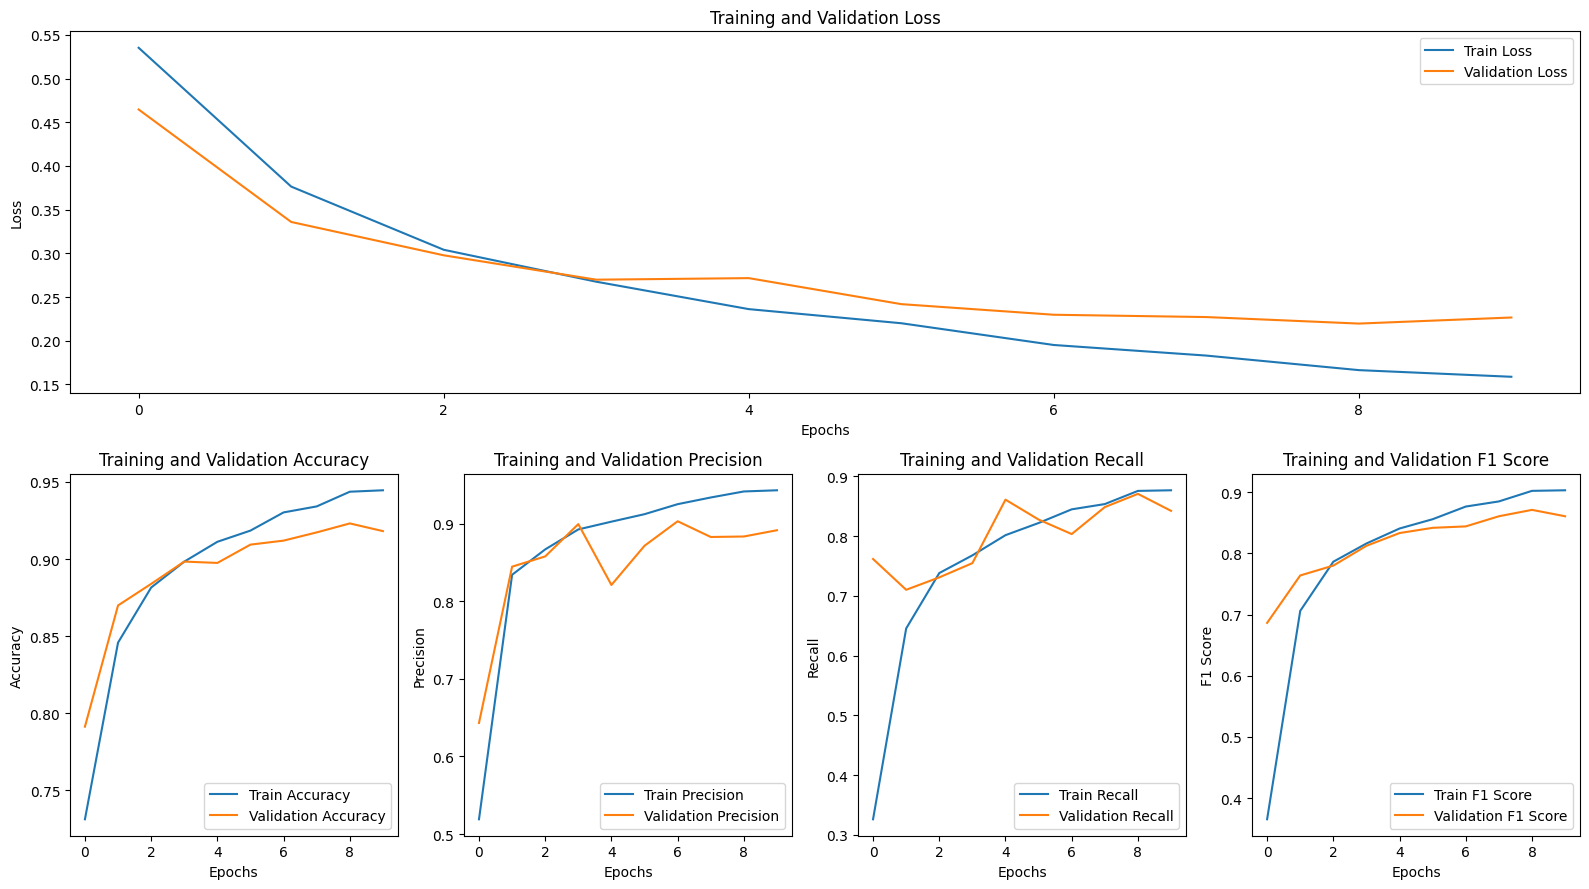

In [25]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

### 7. 평가

In [26]:
# 모델 로드 함수 정의
def load_model(model_path, text_config):
    model = BD_Transformer(text_config)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [29]:
# 저장된 모델 경로
best_model_path = path+'/YouTube(mixed)_Transformers_ACC_0.9231.pth'

In [30]:
# 모델 불러오기
model = load_model(best_model_path, text_config)

In [31]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 71/71 [00:16<00:00,  4.18it/s]


In [32]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.9176
Test Precision: 0.8851
Test Recall: 0.8447
Test F1 Score: 0.8644
Test Confusion Matrix: 
[[1478   77]
 [ 109  593]]
